# Use of several machine learning algorithms on the example of the ratio of height and weight of participants in 3 team sports at the 2016 Summer Olympics


#### On the website www.kaggle.com there is a dataset "2016 Olympics in Rio de Janeiro" which has a csv file "Athletes.csv" which contains data of all athletes who participated in the last Summer Olympics. For each athlete there is an ID column, his name, date of birth, gender, sport, height, weight, country, and number of medals. As it is known, at the last Summer Olympics (Rio 2016), Serbia had 3 finalists in team sports. Basketball players, water polo players and women volleyball players reached the finals, and this is a machine learning project that first singles out participants from these three competitions (men's basketball, men's water polo, women's volleyball), graphically displays and analyzes the data, and then enables you to recognize athletes in these three competitions based on their combination of height and weight.



### Announcement of used libraries and packages

In [1]:
import pandas as pd
import numpy as np
import os
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
%matplotlib inline
# the software libraries and packages to be used were announced first

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# then the software packages that will be used for classification purposes

### File loading

In [3]:
data3 = pd.read_csv(r'D:\Filip\Desktop\Rio2016_basket_polo_volley.csv')
data = pd.read_csv(r'D:\Filip\Desktop\athletes.csv')


#### The file "athletes.csv" was loaded on the desktop, but it turned out that there was a problem with the participants of the Olympic water polo tournament, because water polo was not given separately, but only within the so-called water sports. That is why a special subsidiary file "Rio2016_basket_polo_volley.csv" was created, where only athletes from these three competitions were singled out. But in this project, data from the original dataset will be analyzed in parallel, where water polo players are mixed with other participants from water sports in men's competition (dataframe data), as well as completely cleaned data for these three sports (dataframe data3). 

#### Then we will look at the first 5 rows of both tables via the .head () option.

In [4]:
print(data.head(5))
print(data.shape)
print()
data.info()
print()
print(data3.head(5))
print(data3.shape)
# a brief overview of the 11 columns containing these two tables, and its dimensions

          id            name nationality     sex       dob  height  weight  \
0  736041664  A Jesus Garcia         ESP    male  10/17/69    1.72    64.0   
1  532037425      A Lam Shin         KOR  female   9/23/86    1.68    56.0   
2  435962603     Aaron Brown         CAN    male   5/27/92    1.98    79.0   
3  521041435      Aaron Cook         MDA    male    1/2/91    1.83    80.0   
4   33922579      Aaron Gate         NZL    male  11/26/90    1.81    71.0   

       sport  gold  silver  bronze  
0  athletics     0       0       0  
1    fencing     0       0       0  
2  athletics     0       0       1  
3  taekwondo     0       0       0  
4    cycling     0       0       0  
(11538, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  1

### Extracting data for only three sports we are interested in, deleting unnecessary columns and expelling athletes with incomplete height and weight data

In [5]:
data = data[((data.sport == 'volleyball') & (data.sex == 'female')) | 
            ((data.sport == 'basketball') & (data.sex == 'male')) | 
            ((data.sport == 'aquatics') & (data.sex == 'male') & (data.nationality.isin(['SRB','MNE','CRO','HUN','GRE','ITA','ESP','FRA','USA','JPN','AUS','BRA'])))]
print(data.shape, data3.shape)

(682, 11) (492, 11)


#### As it was said, in the dataframe 'data3' only three competitions that interest us have already been singled out (within water sports only water polo players), so here in the dataframe 'data' we have saved only men's basketball, women's volleyball and men's water sports from which we removed all participants from countries that did not participate in the 2016 water polo tournament, so that we have less than 700 of the original over 11 thousand athletes left.

#### Then we will remove from both tables all unnecessary columns that we do not need for this work (id, date of birth and columns about medals).

In [6]:
data.drop('id',axis=1,inplace=True) 
data.drop('dob',axis=1,inplace=True)
data.drop('gold',axis=1,inplace=True)
data.drop('silver',axis=1,inplace=True)
data.drop('bronze',axis=1,inplace=True)
print(data.head(5))
print()

data3.drop('id',axis=1,inplace=True)
data3.drop('dob',axis=1,inplace=True)
data3.drop('gold',axis=1,inplace=True)
data3.drop('silver',axis=1,inplace=True)
data3.drop('bronze',axis=1,inplace=True)
print(data3.head(5))

                   name nationality     sex  height  weight       sport
7         Aaron Younger         AUS    male    1.93   100.0    aquatics
46  Abdoulkarim Fawziya         CMR  female    1.80    67.0  volleyball
75          Adam Decker         HUN    male    2.03   115.0    aquatics
87         Adam Telegdy         HUN    male    1.94    77.0    aquatics
95     Adas Juskevicius         LTU    male    1.94    90.0  basketball

                  name nationality     sex  height  weight       sport
0        Aaron Younger         AUS    male    1.93   100.0    aquatics
1  Abdoulkarim Fawziya         CMR  female    1.80    67.0  volleyball
2          Adam Decker         HUN    male    2.03   115.0    aquatics
3     Adas Juskevicius         LTU    male    1.94    90.0  basketball
4    Adenizia da Silva         BRA  female    1.87    65.0  volleyball


#### And finally, the deletion of athletes with incomplete data.

In [20]:
print(data.shape, data3.shape)
data = data[np.isfinite(data['height'])]
data = data[np.isfinite(data['weight'])]
data3 = data3[np.isfinite(data3['height'])]
data3 = data3[np.isfinite(data3['weight'])]
print(data.shape, data3.shape)
# Athletes who are not given height or weight have now been eliminated, 
# as they will continue to rely on these two data in this project.

(675, 6) (487, 6)
(675, 6) (487, 6)


### Visual Data Presentation

#### We will graphically show all athletes in these three competitions by their weight and height. The dots representing the basketball players are colored in orange, water sports in blue, and the volleyball players in red.

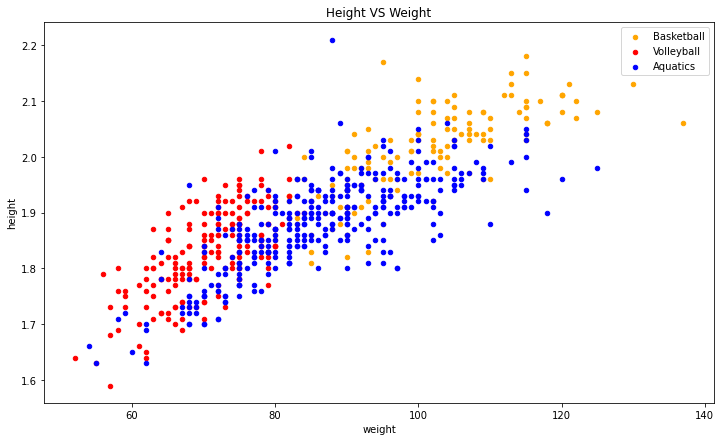

In [8]:
fig = data[data.sport=='basketball'].plot(kind='scatter',x='weight',y='height',color='orange', label='Basketball')
data[data.sport=='volleyball'].plot(kind='scatter',x='weight',y='height',color='red', label='Volleyball',ax=fig)
data[data.sport=='aquatics'].plot(kind='scatter',x='weight',y='height',color='blue', label='Aquatics', ax=fig)
fig.set_xlabel("weight")
fig.set_ylabel("height")
fig.set_title("Height VS Weight")
fig=plt.gcf()
fig.set_size_inches(12,7)
plt.show()

#### And now we will do the same with the table 'data3' in which only water polo players are separated from the representatives of water sports. 

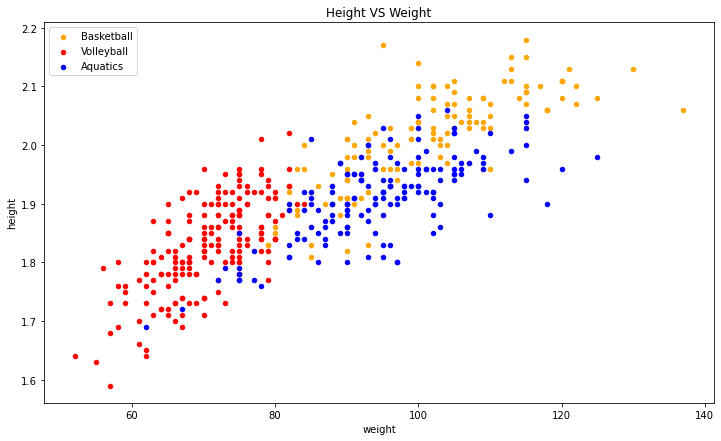

In [21]:
fig = data3[data3.sport=='basketball'].plot(kind='scatter',x='weight',y='height',color='orange', label='Basketball')
data3[data3.sport=='volleyball'].plot(kind='scatter',x='weight',y='height',color='red', label='Volleyball',ax=fig)
data3[data3.sport=='aquatics'].plot(kind='scatter',x='weight',y='height',color='blue', label='Aquatics', ax=fig)
fig.set_xlabel("weight")
fig.set_ylabel("height")
fig.set_title("Height VS Weight")
fig=plt.gcf()
fig.set_size_inches(12,7)
plt.show()
# The same was done with the data frame data 3 where of the "water sports" there are only water polo players from the men's competition

#### Through the appropriate histagrams we see how height and weight are redistributed in these three sports.

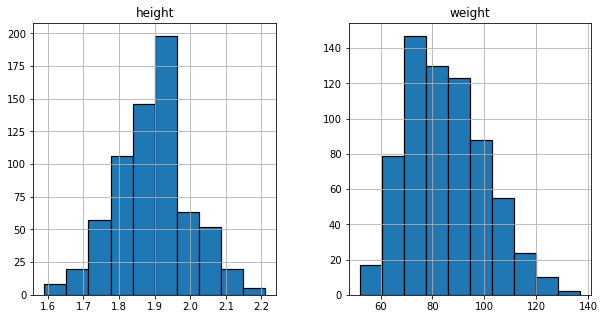

In [22]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

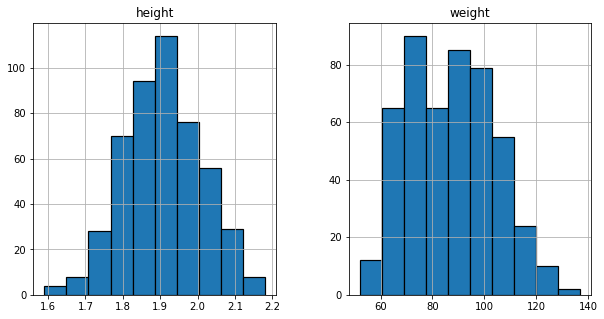

In [23]:
data3.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(10,5)
plt.show()

## Application of Machine Learning

### Division of data frames into training and test part

In [24]:
train, test = train_test_split(data, test_size = 0.25)
print(train.shape, test.shape)

train3, test3 = train_test_split(data3, test_size = 0.25)
print(train3.shape, test3.shape)

trainSRB = data3[(data3.nationality != 'SRB')]
testSRB = data3[(data3.nationality == 'SRB')]
print(trainSRB.shape, testSRB.shape)

(506, 6) (169, 6)
(365, 6) (122, 6)
(450, 6) (37, 6)


#### From both data frames (the one where only water polo players are from water sports, and the one where they are not), a random sample was taken for training and testing in the ratio of 75% / 25%, and for the purposes of experimentation we made a third pair where for the needs of testing serve only selected athletes from Serbia, and for training from the rest of the world.

In [25]:
train_X = train[['height','weight']]
train_y = train.sport
test_X = test[['height','weight']]
test_y = test.sport 

train3_X = train3[['height','weight']]
train3_y = train3.sport
test3_X = test3[['height','weight']]
test3_y = test3.sport

trainSRB_X = trainSRB[['height','weight']]
trainSRB_y = trainSRB.sport
testSRB_X = testSRB[['height','weight']]
testSRB_y = testSRB.sport

#### As already announced in the introduction, our focus is on the height and weight of an athlete in relation to the sport he or she is engaged in, and in parallel we will observe for all these three separate groups that we have determined for training (ie testing).

In [26]:
print(train_X.head(5))
print()
print(train3_X.head(5))
print()
print(trainSRB_X.head(5))

       height  weight
6433     1.74    69.0
2459     1.89    84.0
2904     1.71    67.0
11357    1.80    68.0
3206     1.89    90.0

     height  weight
153    1.85    83.0
483    1.77    72.0
181    2.04   115.0
393    1.93    99.0
296    2.03   100.0

   height  weight
0    1.93   100.0
1    1.80    67.0
2    2.03   115.0
3    1.94    90.0
4    1.87    65.0


#### Let's notice the differences between all three samples based on the first five athletes who belong to them

In [27]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# In each case, we blocked the warning option so as not to create confusion 
# when presenting the results of different classification and machine learning algorithms.

### SVM (support vector machines)

#### We will first test the SVM algorithm (Support Vector Machines) and determine with what precision it will correctly classify the sport only on the basis of the athlete's height and weight.

In [29]:
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('Precision of SVM algorithm is (data):',round(metrics.accuracy_score(prediction,test_y), 2))

model = svm.SVC()
model.fit(train3_X,train3_y)
prediction=model.predict(test3_X)
print('Precision of SVM algorithm is (data3):',round(metrics.accuracy_score(prediction,test3_y), 2))

model = svm.SVC()
model.fit(trainSRB_X,trainSRB_y)
prediction=model.predict(testSRB_X)
print('Precision of SVM algorithm is (dataSRB):',round(metrics.accuracy_score(prediction,testSRB_y), 2))



Precision of SVM algorithm is (data): 0.69
Precision of SVM algorithm is (data3): 0.69
Precision of SVM algorithm is (dataSRB): 0.73


### Logistic Regression 

In [30]:
model = LogisticRegression()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
print('Precision of Logistic Regression algorithm is (data):',round(metrics.accuracy_score(prediction,test_y),2 ))

model = LogisticRegression()
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Precision of Logistic Regression algorithm (data3):',round(metrics.accuracy_score(prediction,test3_y), 2))

model = LogisticRegression()
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Precision Logistic Regression algorithm is (dataSRB):',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# We then tested logistic Regression on all three samples

Precision of Logistic Regression algorithm is (data): 0.73
Precision of Logistic Regression algorithm (data3): 0.75
Precision Logistic Regression algorithm is (dataSRB): 0.76


### Decision Tree Classifier 

In [32]:
model = DecisionTreeClassifier()
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('Precision of Decision Tree algorithm is (data)',round(metrics.accuracy_score(prediction,test_y),2 ))

model = DecisionTreeClassifier()
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Precision of Decision Tree algorithm is (data3)',round(metrics.accuracy_score(prediction,test3_y), 2))

model = DecisionTreeClassifier()
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Precision of Decision Tree algorithm is (dataSRB)',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# The next examined algorithm was Decision Tree Classifier and its precision of prediction on these 3 samples

Precision of Decision Tree algorithm is (data) 0.6
Precision of Decision Tree algorithm is (data3) 0.8
Precision of Decision Tree algorithm is (dataSRB) 0.73


### KNN (k-Nearest Neighbor)

In [33]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_X,train_y)
prediction = model.predict(test_X)
print('Precision of KNN algorithm is (data)',round(metrics.accuracy_score(prediction,test_y), 2))

model = KNeighborsClassifier(n_neighbors=3)
model.fit(train3_X,train3_y)
prediction = model.predict(test3_X)
print('Precision of KNN algorithm is (data)',round(metrics.accuracy_score(prediction,test3_y), 2))

model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainSRB_X,trainSRB_y)
prediction = model.predict(testSRB_X)
print('Precision of KNN algorithm is (data)',round(metrics.accuracy_score(prediction,testSRB_y), 2))

# Finally, the KNN algorithm (k-Nearest Neighbor) and its prediction accuracy on these 3 samples were tested.

Precision of KNN algorithm is (data) 0.67
Precision of KNN algorithm is (data) 0.8
Precision of KNN algorithm is (data) 0.7


## Conclusion based on results 

#### Only on the basis of the height and weight of the athlete in the group where basketball players, water polo players and volleyball players are mixed, it is possible to guess relatively successfully who is exactly the right representative of the sport.

#### We got visibly greater precision where water polo players were separated from other water sports, because the regularity in the ratio of height and weight in water polo players is clearer than in the representatives of water sports as a whole.

#### We achieved the highest precision where we singled out only Serbian athletes, and trained on everyone else. This happened despite the fact that Serbian volleyball players were on average in height and weight above the average for their sport, and therefore more similar to water polo players and basketball guards, and that Serbian water polo players were also on average above average for their sport, and therefore closer to basketball players. But since they all reached the finals, then it is to be expected that more than average, their height-weight ratio fits into some ideal standards that apply to their sport in all three cases (Serbian basketball players, water polo players and volleyball players).

